### Data Fields
- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.

- channelGrouping - The channel via which the user came to the Store.

- date - The date on which the user visited the Store.

- device - The specifications for the device used to access the Store.

- geoNetwork - This section contains information about the geography of the user.

- sessionId - A unique identifier for this visit to the store.

- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".

- totals - This section contains aggregate values across the session.

- trafficSource - This section contains information about the Traffic Source from which the session originated.

- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

- visitNumber - The session number for this user. If this is the first session, then this is set to 1.

- visitStartTime - The timestamp (expressed as POSIX time).

### Removed Data Fields
Some fields were censored to remove target leakage. The major censored fields are listed below.

- hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.

- customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.

- totals - Multiple sub-columns were removed from the totals field.

Data (116 MB)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import gc
from utils.load_df import *
from tqdm import tqdm_notebook, tnrange
from sklearn import model_selection, preprocessing, metrics
from datetime import date,timedelta
data_dir = "./datasetsV2/data/"
sub_dir = 'submission/'
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='1'

%matplotlib

Using matplotlib backend: Qt5Agg


In [2]:
def downCast_dtype(df):
    '''
        对数据类型进行转换
    '''
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype == 'int64']
    
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)
    
    return df
def remove_const_cols(df_train,df_test):
    #查询出具有列元素全部相同的列名
    const_cols = [c for c in tqdm_notebook(df_test.columns) if df_test[c].nunique(dropna=False)==1 and c!='totals.visits']
    if len(const_cols):
        dropCols = const_cols +['trafficSource.adwordsClickInfo.page']+['totals.totalTransactionRevenue']+['totals.transactions']
        df_test = df_test.drop(dropCols,axis=1)
        df_train = df_train.drop(dropCols+['trafficSource.campaignCode'],axis=1)
    return df_train,df_test
# 加载原始数据
tr_path = data_dir + 'train_v2.csv'
te_path = data_dir + 'test_v2.csv'

df_train,df_test = get_df(tr_path,te_path)

print(df_train.shape)
print(df_test.shape)
print(set(df_train.columns) - (set(df_train.columns) & set(df_test.columns)))

df_train,df_test = remove_const_cols(df_train,df_test)
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].fillna(0)
df_test['totals.transactionRevenue'] = df_test['totals.transactionRevenue'].fillna(0)

df_data = pd.concat((df_train,df_test))
df_data = downCast_dtype(df_data)
df_data.sort_values(['fullVisitorId','date'],inplace=True)
print(df_train.shape,df_test.shape)
print(df_data.shape)

In [5]:
%%time

def dateHandle(df):
    
    holiday = ['01-01','02-01','02-12','02-14','02-22','03-07','03-17','04-01','05-01','05-14',
               '06-01','06-21','06-14','07-01','08-01','09-01','10-01','10-31','11-01','11-11',
               '12-24','12-25']
    df['vtime'] = pd.to_datetime(df['visitStartTime'],unit='s')
    df['month'] = df['vtime'].dt.month
    df['week'] = df['vtime'].dt.week
    df['day'] = df['vtime'].dt.day
    df["weekOfday"] = df['vtime'].dt.weekday
    for h in holiday:
        h_month,h_day = h.split('-')
        df['is_holiday'] = ((df['month']==int(h_month))&(df['day']==int(h_day))|(df['weekOfday']==5)|(df['weekOfday']==6))*1

    #某日前七日天、和后两天是否为假期
    for i in range(1,8):
        df['pre%s_day_is_holiday'%i] = df['is_holiday'].shift(i).fillna(0)
        df['next%s_day_is_holiday'%i] = df['is_holiday'].shift(-i).fillna(0)

    df['month.unique.user.count'] = df.groupby('month')['fullVisitorId'].transform('nunique')
    df['day.unique.user.count'] = df.groupby('day')['fullVisitorId'].transform('nunique')
    df['weekday.unique.user.count'] = df.groupby('weekOfday')['fullVisitorId'].transform('nunique')

    df['next_session_1'] = (
        df['vtime'] - df[['fullVisitorId', 'vtime']].groupby('fullVisitorId')['vtime'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60
    df['next_session_2'] = (
        df['vtime'] - df[['fullVisitorId', 'vtime']].groupby('fullVisitorId')['vtime'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60

    days_of_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    #当天距离月初月末的距离
    df["days_to_side"] = df['vtime'].apply(lambda x: min(x.day, days_of_months[x.month-1]-x.day))
    df['day'] = df['day'].apply(lambda x:0 if x<=7 else 2 if x>=24 else 1)
    
    df.drop(columns=['vtime'],inplace=True)
    
    return df

df_data = dateHandle(df_data)

print(df_data.shape)

(2109926, 61)
CPU times: user 23.9 s, sys: 1.08 s, total: 24.9 s
Wall time: 24.7 s


In [7]:
def getLagFeatures(df, time_col, group_cols, shifts):    
    '''
    For epoch time, compute deltas with the specified shift on sequences
    aggregated by group_cols, return df with new columns
    '''
    df = df.sort_values(by=time_col)
    for shift in shifts:
        feat_name = '_'.join(group_cols) + ('_delta_shift_%d' % shift) 
        
        df[feat_name] = (df.groupby(group_cols)
                            [time_col].shift(shift) - df[time_col]).astype(np.float32)
        df[feat_name] = df[feat_name] * -1 * np.sign(shift) # flip sign for lags
        df[feat_name] = df[feat_name].fillna(0)
    return df

lags = [x for x in range(-6,7) if x!=0]
df_data = getLagFeatures(df_data,'visitStartTime',['fullVisitorId'],lags)

### 基本特征+交互特征

In [8]:
#基本特征+交互特征
staticsCols = ['totals.bounces','totals.hits','totals.newVisits','totals.pageviews','totals.sessionQualityDim',
               'totals.timeOnSite','totals.transactionRevenue','totals.visits']
#交互特征
def getInteracFeatures(df,cols=None,method='/'):
    if(method=='/'):
        df['%s/%s'%(cols[0],cols[1])] = df[cols[0]].values/(df[cols[1]].values+1)
    df['%s/%s'%(cols[0],cols[1])].fillna(0,inplace=True)
    staticsCols.append('%s/%s'%(cols[0],cols[1]))
    return df

df_data = getInteracFeatures(df_data,cols=['totals.timeOnSite','totals.pageviews'])
df_data = getInteracFeatures(df_data,cols=['totals.bounces','totals.hits'])
df_data = getInteracFeatures(df_data,cols=['totals.hits','totals.timeOnSite'])

In [9]:
#设备&网络特征
def getDeviceFeature(df,groups=None,feaCols=None):
    feCols = []
    for group in groups:
        for fe in feaCols:
            df['sum_%s_By%s'%(fe,group)] = df.groupby(group)[fe].transform('sum')
            df['mean_%s_By%s'%(fe,group)] = df.groupby(group)[fe].transform('mean')
            feCols.append('sum_%s_By%s'%(fe,group))
            feCols.append('mean_%s_By%s'%(fe,group))
    df.fillna(0,inplace=True)
    return df,feCols
deviceCols = []
deviceGroups = ['device.browser','device.operatingSystem','device.isMobile','device.deviceCategory',
                'geoNetwork.networkDomain']
# totalCols = ['totals.hits','totals.transacationRevenue','totals.visits','totals.pageviews',
#              'totals.timeOnSite','totals.sessionQualityDim']

df_data,deviceCols = getDeviceFeature(df_data,groups=deviceGroups,feaCols=staticsCols)

df_data = downCast_dtype(df_data)

In [10]:
featCols = ['totals.pageviews','totals.timeOnSite','totals.transactionRevenue',
            'totals.timeOnSite/totals.pageviews']
for col in featCols:
    df_data['log_'+col] = df_data[col].apply(lambda x:np.log1p(float(x)) if float(x) > 0 else 0)
    staticsCols.append('log_'+col)

### 类别特征

In [11]:
#类别特征处理
device_browers = list(df_data['device.browser'].value_counts().reset_index()['index'][0:30])
device_os = list(df_data['device.operatingSystem'].value_counts().reset_index()['index'][0:15])

geoNetwork_cities = list(df_data['geoNetwork.city'].value_counts().reset_index()['index'][0:10])
geoNetwork_country = list(df_data['geoNetwork.country'].value_counts().reset_index()['index'][0:20])
geoNetwork_metro = list(df_data['geoNetwork.metro'].value_counts().reset_index()['index'][0:40])
geoNetwork_networkDomain = list(df_data['geoNetwork.networkDomain'].value_counts().reset_index()['index'][0:40])

def browser_mapping(x):
    if x in device_browers:
        return x.lower()
    else:
        return 'others'

def geoNetwork_city(x):
    if x in geoNetwork_cities:
        return x.lower()
    else:
        return 'others'
    
def geoNetwork_countries(x):
    if x in geoNetwork_country:
        return x.lower()
    else:
        return 'others'

def adcontents_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'
    
def device_operatingSystem(x):
    if x in device_os:
        return x.lower()
    else:
        return 'others'

def traficSource_referralPath(x):
    if x == '/':
        return '/'
    elif 'yt/about/' in x:
        return x
    elif 'google' in x:
        return '/google'
    elif 'mail' in x:
        return '/mail'
    elif 'yt/advertise/' in x:
        return x
    elif 'offer/2145' in x:
        return x
    elif 'yt/creators/' in x:
        return x
    elif 'pagead/ads' in x:
        return x
    elif '/intl/' in x:
        return x;
    elif 'shirt' in x:
        return x;
    elif '/analytics/app/' in x:
        return x
    elif 'using-the-logo':
        return x
    elif '/moma' in x:
        return x
    else:
        return '/others'  
    
def source_mapping(x):
    if  ('google' in x):
        return 'google'
    elif('(direct)'in x):
        return x;
    elif  ('youtube' in x):
        return 'youtube'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'pinterest' in x:
        return 'pinterest'
    elif 'ask' in x:
        return 'ask'
    elif 'siliconvalley' in x:
        return 'siliconvalley'
    elif 'lunametrics' in x:
        return 'lunametrics'
    elif 'amazon' in x:
        return 'amazon'
    elif 'mysearch' in x:
        return 'mysearch'
    elif 'qiita' in x:
        return 'qiita'
    elif 'messenger' in x:
        return 'messenger'
    elif 'twitter' in x:
        return 'twitter'
    elif 't.co' in x:
        return 't.co'
    elif 'vk.com' in x:
        return 'vk.com'
    elif 'search' in x:
        return 'search'
    elif 'edu' in x:
        return 'edu'
    elif 'mail' in x:
        return 'mail'
    elif 'ad' in x:
        return 'ad'
    elif 'golang' in x:
        return 'golang'
    elif 'direct' in x:
        return 'direct'
    elif 'dealspotr' in x:
        return 'dealspotr'
    elif 'sashihara' in x:
        return 'sashihara'
    elif 'phandroid' in x:
        return 'phandroid'
    elif 'baidu' in x:
        return 'baidu'
    elif 'mdn' in x:
        return 'mdn'
    elif 'duckduckgo' in x:
        return 'duckduckgo'
    elif 'seroundtable' in x:
        return 'seroundtable'
    elif 'metrics' in x:
        return 'metrics'
    elif 'sogou' in x:
        return 'sogou'
    elif 'businessinsider' in x:
        return 'businessinsider'
    elif 'github' in x:
        return 'github'
    elif 'gophergala' in x:
        return 'gophergala'
    elif 'yandex' in x:
        return 'yandex'
    elif 'msn' in x:
        return 'msn'
    elif 'dfa' in x:
        return 'dfa'
    elif 'feedly' in x:
        return 'feedly'
    elif 'arstechnica' in x:
        return 'arstechnica'
    elif 'squishable' in x:
        return 'squishable'
    elif 'flipboard' in x:
        return 'flipboard'
    elif 't-online.de' in x:
        return 't-online.de'
    elif 'sm.cn' in x:
        return 'sm.cn'
    elif 'wow' in x:
        return 'wow'
    elif 'baidu' in x:
        return 'baidu'
    elif 'partners' in x:
        return 'partners'
    else:
        return 'others'

for df in [df_data]:  
    df['device.browser'] = df['device.browser'].map(lambda x:browser_mapping(str(x))).astype('str')
    df['device.operatingSystem'] = df['device.operatingSystem'].map(lambda x:device_operatingSystem(str(x))).astype('str')
    df['trafficSource.adContent'] = df['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
    df['trafficSource.source'] = df['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')
    df['geoNetwork.city'] = df['geoNetwork.city'].map(lambda x:geoNetwork_city(str(x))).astype('str')
    df['geoNetwork.country'] = df['geoNetwork.country'].map(lambda x:geoNetwork_countries(str(x))).astype('str')
    df['trafficSource.referralPath'] = df['trafficSource.referralPath'].map(lambda x:traficSource_referralPath(str(x))).astype('str')

#将具有从属关系的特征进行合并:地区从属关系，市场分区
for df in [df_data]:
    print("... process device ...")
    df['source.country'] = df['trafficSource.source'] + '_' + df['geoNetwork.country']
    df['campaign.medium'] = df['trafficSource.campaign'] + '_' + df['trafficSource.medium']
    df['browser.category'] = df['device.browser'] + '_' + df['device.deviceCategory']
    df['browser.os'] = df['device.browser'] + '_' + df['device.operatingSystem']

#将设备中具有从属关系的特征整合
def getCustormFeature(df):
    print('... custom ...')
    df['device_deviceCategory_channelGrouping'] = df['device.deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device.browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device.operatingSystem'] + "_" + df['channelGrouping']
    
    df['city_continent_country_metro_networkDomain_region_subContinent'] = df['geoNetwork.city']+"_"+df['geoNetwork.continent']+"_"+df['geoNetwork.country']+"_"+df['geoNetwork.metro']+"_"+df['geoNetwork.networkDomain']+"_"+df['geoNetwork.region']+df['geoNetwork.subContinent']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content.source'] = df['trafficSource.adContent'] + "_" + df['source.country']
    df['medium.source'] = df['trafficSource.medium'] + "_" + df['source.country']
    
    return df

df_data = getCustormFeature(df_data)

print(df_data.shape)

... process device ...
... custom ...
(2109926, 228)


### Label Encoding

In [12]:
from sklearn.preprocessing import LabelEncoder
excluded_cols = ['fullVisitorId','date','totals.transactionRevenue','visitStartTime']
cat_cols = [col for col in df_data.columns if df_data[col].dtype =="object" and col not in excluded_cols]
# label encode the categorical variables and convert the numerical variables to float
def label_encoding(df_data):
    for col in tqdm_notebook(cat_cols):
        if df_data[col].dtype == bool:#将bool变量转成整数
            df_data[col] = df_data[col].astype(int)
        lbl = LabelEncoder()
        lbl.fit(list(df_data[col].values.astype('str')))
        
        df_data[col] = lbl.transform(list(df_data[col].values.astype('str')))
        
    return df_data

df_data = label_encoding(df_data)

In [13]:
# from utils.funcUtils import *
def feat_count(df_feature,fe,value,name=""):
    df_feature[name] = df_feature.groupby(fe)[value].transform('count')
    return df_feature
def feat_mean(df_feature,fe,value,name=""):
    df_feature[name] = df_feature.groupby(fe)[value].transform('mean')
    return df_feature
def feat_max(df_feature,fe,value,name=""):
    df_feature[name] = df_feature.groupby(fe)[value].transform('max')
    return df_feature
def feat_median(df_feature,fe,value,name=""):
    df_feature[name] = df_feature.groupby(fe)[value].transform('median')
    return df_feature
def feat_sum(df_feature,fe,value,name=""):
    df_feature[name] = df_feature.groupby(fe)[value].transform('sum') 
    return df_feature
def feat_min(df_feature,fe,value,name=""):
    df_feature[name] = df_feature.groupby(fe)[value].transform('min')
    return df_feature
def feat_std(df_feature,fe,value,name=""):
    df_feature[name] = df_feature.groupby(fe)[value].transform('std')
    return df_feature

def getFeatures(df):
    
    featCols = ['totals.visits','totals.timeOnSite','log_totals.pageviews',
                'totals.sessionQualityDim','log_totals.transactionRevenue']
    
    for col in featCols:
        df = feat_sum(df,['fullVisitorId','date'],col,'%s_sum_date'%col)
        df = feat_mean(df,['fullVisitorId','date'],col,'%s_mean_date'%col)
        df = feat_std(df,['fullVisitorId','date'],col,'%s_std_date'%col)
        df = feat_median(df,['fullVisitorId','date'],col,'%s_median_date'%col)

        df = feat_sum(df,['fullVisitorId','day','weekOfday'],col,'%s_sumOfweekday'%col)
        df = feat_sum(df,['fullVisitorId','day','is_holiday'],col,'%s_sumOfholiday'%col)
        df = feat_mean(df,['fullVisitorId','day','weekOfday'],col,'%s_meanOfweekday'%col)
        df = feat_mean(df,['fullVisitorId','day','is_holiday'],col,'%s_meanOfholiday'%col)

        df = feat_sum(df,['fullVisitorId','days_to_side'],col,'%s_sumOfdaySlide'%col)
        df = feat_mean(df,['fullVisitorId','days_to_side'],col,'%s_meanOfdaySlide'%col)

        df = feat_median(df,['fullVisitorId'],col,'%s_median'%col)
        df = feat_mean(df,['fullVisitorId'],col,'%s_mean'%col)
        df = feat_max(df,['fullVisitorId'],col,'%s_max'%col)
        df = feat_min(df,['fullVisitorId'],col,'%s_min'%col)
        df = feat_sum(df,['fullVisitorId'],col,'%s_sum'%col)

        df = feat_mean(df,['fullVisitorId','month'],col,'%s_month_mean'%col)
        df = feat_max(df,['fullVisitorId','month'],col,'%s_month_max'%col)
        df = feat_min(df,['fullVisitorId','month'],col,'%s_month_min'%col)
        df = feat_sum(df,['fullVisitorId','month'],col,'%s_month_sum'%col)

        df = feat_mean(df,['fullVisitorId','weekOfday'],col,'%s_week_mean'%col)
        df = feat_max(df,['fullVisitorId','weekOfday'],col,'%s_week_max'%col)
        df = feat_min(df,['fullVisitorId','weekOfday'],col,'%s_week_min'%col)
        df = feat_count(df,['fullVisitorId','weekOfday'],col,'%s_week_count'%col)
        df = feat_sum(df,['fullVisitorId','weekOfday'],col,'%s_week_sum'%col)

        #节假日
        df = feat_mean(df,['fullVisitorId','is_holiday'],col,'%s_holiday_mean'%col)
        df = feat_max(df,['fullVisitorId','is_holiday'],col,'%s_holiday_max'%col)
        df = feat_min(df,['fullVisitorId','is_holiday'],col,'%s_holiday_min'%col)
        df = feat_sum(df,['fullVisitorId','is_holiday'],col,'%s_holiday_sum'%col)

    df.fillna(0,inplace=True)
    
    return df

### 特征文件保存

In [14]:
df_data.replace([np.inf,-np.inf],np.nan,inplace=True)
df_data.fillna(0,inplace=True)
df_data.to_csv('./features/df_data.csv',index=None)

In [15]:
%%time

def dateGap(x,y):
    yearx = x[:4]
    monthx = x[4:6]
    dayx = x[6:]
    
    yeary = y[:4]
    monthy = y[4:6]
    dayy = y[6:]
    
    return (date(int(yearx),int(monthx),int(dayx)) - date(int(yeary),int(monthy),int(dayy))).days

tr_periods = [
    ('20160801', '20170115'),
    ('20170116', '20170630'),
    ('20170701', '20171215'),
    ('20171216', '20180601'),
    ('20170501', '20171015'),
]
te_periods = [
    ('20170301', '20170430'),
    ('20170715', '20170915'),
    ('20180201', '20180331'),
    ('20180715', '20180915'),
    ('20171201', '20180131'),
]

df_test = df_data[(df_data.date>='20180501')&(df_data.date<='20181015')]
df_test['day_gap'] = df_test['date'].apply(lambda x:dateGap(x,str('20181201')))
df_test = getFeatures(df_test)

print(df_test.shape)

for i,(tr,te) in enumerate(zip(tr_periods,te_periods)):
    (tr_start,tr_end),(te_start,te_end) = tr,te
    print((tr_start,tr_end))
    df_train = df_data[(df_data.date>=tr_start)&(df_data.date<=tr_end)]
    df_train['day_gap'] = df_train['date'].apply(lambda x:dateGap(x,str(te_start)))
    df_train = getFeatures(df_train)
    
    df = df_data[(df_data.date>=te_start)&(df_data.date>=te_end)][['fullVisitorId','totals.transactionRevenue']]
    df = df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
    df['y_class'] = ((df['totals.transactionRevenue']>0).astype(np.uint8)).values
    df['y_reg'] = (df['totals.transactionRevenue'].apply(lambda x:np.log1p(float(x)) if float(x) > 0 else 0)).values
   
    print("相同用户百分比:%s%s"%(
                str(len((set(df_train.fullVisitorId) & set(df.fullVisitorId)))/len(set(df_train.fullVisitorId))*100),'%'
            ))
        
    df.drop(columns=['totals.transactionRevenue'],inplace=True)
        
    df_train = df_train.merge(df,on=['fullVisitorId'],how='left')
    df_train.fillna(0,inplace=True)
    
    df_train.to_csv('./features/df_trv%s.csv'%i,index=None)

df_test.to_csv('./features/df_test.csv',index=None)   

/home/sjtu123/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sjtu123/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sjtu123/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

(401589, 369)
('20160801', '20170115')


/home/sjtu123/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



相同用户百分比:0.6386769392289215%
('20170116', '20170630')
相同用户百分比:0.9436143160372402%
('20170701', '20171215')
相同用户百分比:0.6761987395634712%
('20171216', '20180601')
相同用户百分比:0.1790620094191523%
('20170501', '20171015')
相同用户百分比:0.7241320729531968%
CPU times: user 27min 6s, sys: 1min 9s, total: 28min 15s
Wall time: 28min 16s


### Classification and Regression With GroupKFold
   * lgbclf/reg
   * xgbclf/reg
   * catclf/reg

In [16]:
%% time
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import xgboost as xgb
import catboost as catb

def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

#GroupKFold 交叉验证输出
def getGroupKFoldReg(model,x_train,y_train,x_test):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    NFOLDS = 10

    folds = get_folds(df=x_train, n_splits=NFOLDS)

    oof_train_pred = np.zeros((ntrain,))
    oof_test_pred = np.zeros((ntest,))
    oof_test_pred_skf = np.empty((NFOLDS, ntest))
    #针对不同的模型采用不同的训练方式
    for i, (dev_index, val_index) in enumerate(folds):
        x_dev = x_train[tr_features].iloc[dev_index]
        y_dev = y_train.iloc[dev_index]
        x_val = x_train[tr_features].iloc[val_index]
        y_val = y_train.iloc[val_index]

        model.fit(x_dev, y_dev,eval_set=[(x_dev,y_dev),(x_val,y_val)],early_stopping_rounds=50,verbose=100)

        oof_test_pred_skf[i, :] = model.predict(x_test[tr_features],num_iteration=model.best_iteration_)
        oof_train_pred[val_index] = model.predict(x_val,num_iteration=model.best_iteration_)

    oof_test_pred_skf[oof_test_pred_skf<0] = 0
    oof_test_pred[:] = np.expm1(oof_test_pred_skf).mean(axis=0)
    oof_train_pred = np.expm1(oof_train_pred)

    print("-"*50+str("model training done！")+"-"*50)

    return model,oof_test_pred.reshape(-1, 1),oof_train_pred.reshape(-1,1)

def getGroupKFoldReg2(model,x_train,y_train,x_test):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    NFOLDS = 10
    
    folds = get_folds(df=x_train, n_splits=NFOLDS)
    
    oof_train_pred = np.zeros((ntrain,))
    oof_test_pred = np.zeros((ntest,))
    oof_test_pred_skf = np.empty((NFOLDS, ntest))
    #针对不同的模型采用不同的训练方式
    for i, (dev_index, val_index) in enumerate(folds):
        x_dev = x_train[tr_features].iloc[dev_index]
        y_dev = y_train.iloc[dev_index]
        x_val = x_train[tr_features].iloc[val_index]
        y_val = y_train.iloc[val_index]

        model.fit(x_dev, y_dev,eval_set=[(x_dev,y_dev),(x_val,y_val)],early_stopping_rounds=50,verbose=100)
    
        oof_test_pred_skf[i, :] = model.predict(x_test[tr_features])
        oof_train_pred[val_index] = model.predict(x_val)
    
    oof_test_pred_skf[oof_test_pred_skf<0] = 0
    oof_test_pred[:] = np.expm1(oof_test_pred_skf).mean(axis=0)
    oof_train_pred = np.expm1(oof_train_pred)
    
    print("-"*50+str("model training done！")+"-"*50)
    
    return model,oof_test_pred.reshape(-1, 1),oof_train_pred.reshape(-1,1)
#注意分类样本存在不平衡
def getGroupKFoldClf(clf,x_train,y_train,x_test):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    NFOLDS = 5
    
    folds = get_folds(df=x_train, n_splits=NFOLDS)
    oof_train_pred = np.zeros((ntrain,2))
    oof_test_pred = np.zeros((ntest,2))
    oof_test_pred_skf = np.empty((ntest,2,NFOLDS))
  
    for i, (dev_index, val_index) in enumerate(folds):
        x_dev = x_train[tr_features].iloc[dev_index]
        y_dev = y_train.iloc[dev_index]
        x_val = x_train[tr_features].iloc[val_index]
        y_val = y_train.iloc[val_index]

        clf.fit(x_dev, y_dev,eval_set=[(x_dev,y_dev),(x_val,y_val)],early_stopping_rounds=100,verbose=100)
        
        oof_test_pred_skf[:,:,i] = clf.predict_proba(x_test[tr_features],num_iteration=clf.best_iteration_)
        oof_train_pred[val_index,:] = clf.predict_proba(x_val,num_iteration=clf.best_iteration_)
            
    oof_test_pred[:] = oof_test_pred_skf.mean(axis=-1)
    
    print("-"*50+str("clf training done！")+"-"*50)
    
    return clf,oof_test_pred,oof_train_pred

## XGB Classifier
def getGroupKFoldClf2(clf,x_train,y_train,x_test):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    NFOLDS = 10
    
    folds = get_folds(df=x_train, n_splits=NFOLDS)

    oof_train_pred = np.zeros((ntrain,2))
    oof_test_pred = np.zeros((ntest,2))
    oof_test_pred_skf = np.empty((ntest,2,NFOLDS))

    for i, (dev_index, val_index) in enumerate(folds):
        x_dev = x_train[tr_features].iloc[dev_index]
        y_dev = y_train.iloc[dev_index]
        x_val = x_train[tr_features].iloc[val_index]
        y_val = y_train.iloc[val_index]

        clf.fit(x_dev, y_dev,eval_set=[(x_dev,y_dev),(x_val,y_val)],early_stopping_rounds=100,verbose=100)
    
        oof_test_pred_skf[:,:,i] = clf.predict_proba(x_test[tr_features])
        oof_train_pred[val_index] = clf.predict_proba(x_val)
        
    oof_test_pred[:] = oof_test_pred_skf.mean(axis=-1)

    print("-"*50+str("clf training done！")+"-"*50)
    
    return clf,oof_test_pred,oof_train_pred

CPU times: user 26.7 ms, sys: 7.69 ms, total: 34.4 ms
Wall time: 32.9 ms


................................training_0...........................
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0395356	valid_1's binary_logloss: 0.0477295
[200]	training's binary_logloss: 0.00669256	valid_1's binary_logloss: 0.0165012
[300]	training's binary_logloss: 0.00210284	valid_1's binary_logloss: 0.0136772
[400]	training's binary_logloss: 0.000838441	valid_1's binary_logloss: 0.0138601
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00108068	valid_1's binary_logloss: 0.0136006
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.042906	valid_1's binary_logloss: 0.0604527
[200]	training's binary_logloss: 0.00861465	valid_1's binary_logloss: 0.0207015
[300]	training's binary_logloss: 0.00321064	valid_1's binary_logloss: 0.0156538
[400]	training's binary_logloss: 0.00145294	valid_1's binary_logloss: 0.0129996
[500]	training's binary_logloss: 0.000690203	valid_

100:	learn: 0.0159752	test: 0.0159752	test1: 0.0796223	best: 0.0652524 (63)	total: 19.2s	remaining: 15m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.06525241089
bestIteration = 63

Shrink model to first 64 iterations.
0:	learn: 0.6154192	test: 0.6154192	test1: 0.6139442	best: 0.6139442 (0)	total: 183ms	remaining: 15m 14s
100:	learn: 0.0148649	test: 0.0148649	test1: 0.1144678	best: 0.0875143 (50)	total: 19.3s	remaining: 15m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08751429314
bestIteration = 50

Shrink model to first 51 iterations.
0:	learn: 0.6120613	test: 0.6120613	test1: 0.6139944	best: 0.6139944 (0)	total: 182ms	remaining: 15m 11s
100:	learn: 0.0145117	test: 0.0145117	test1: 0.1867519	best: 0.1334928 (35)	total: 19.3s	remaining: 15m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1334928056
bestIteration = 35

Shrink model to first 36 iterations.
0:	learn: 0.6066449	test: 0.6066449	test1: 0.6282013	

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:0.624489	validation_1-rmse:0.672365
[200]	validation_0-rmse:0.5408	validation_1-rmse:0.66463
[300]	validation_0-rmse:0.491491	validation_1-rmse:0.6641
Stopping. Best iteration:
[261]	validation_0-rmse:0.510616	validation_1-rmse:0.662752

[0]	validation_0-rmse:0.881689	validation_1-rmse:1.48626
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:0.631525	validation_1-rmse:1.41983
Stopping. Best iteration:
[146]	validation_0-rmse:0.58695	validation_1-rmse:1.41735

--------------------------------------------------model training done！--------------------------------------------------
0:	learn: 0.8558915	test: 0.8558915	test1: 0.7310828	best: 0.7310828 (0)	total: 75.3ms	remaining: 

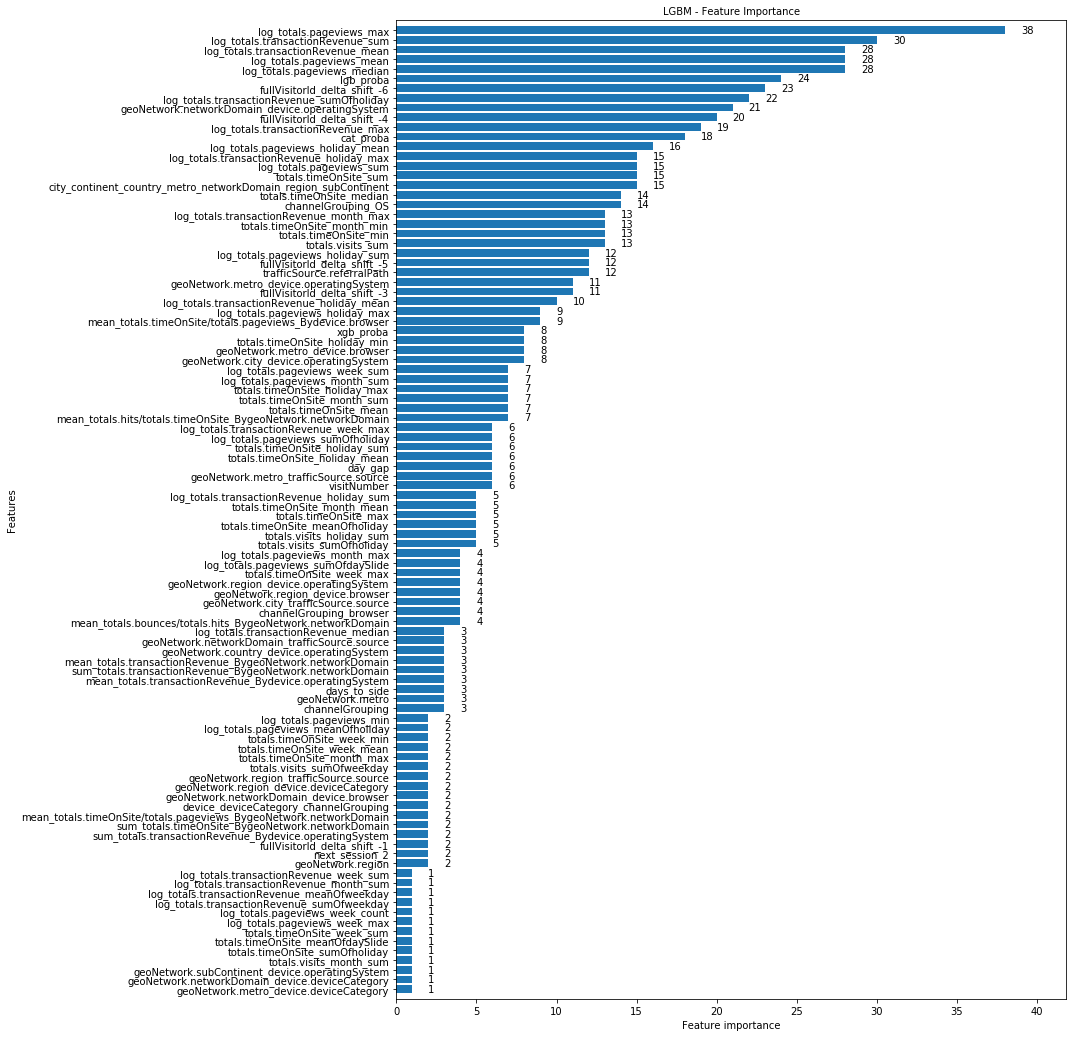

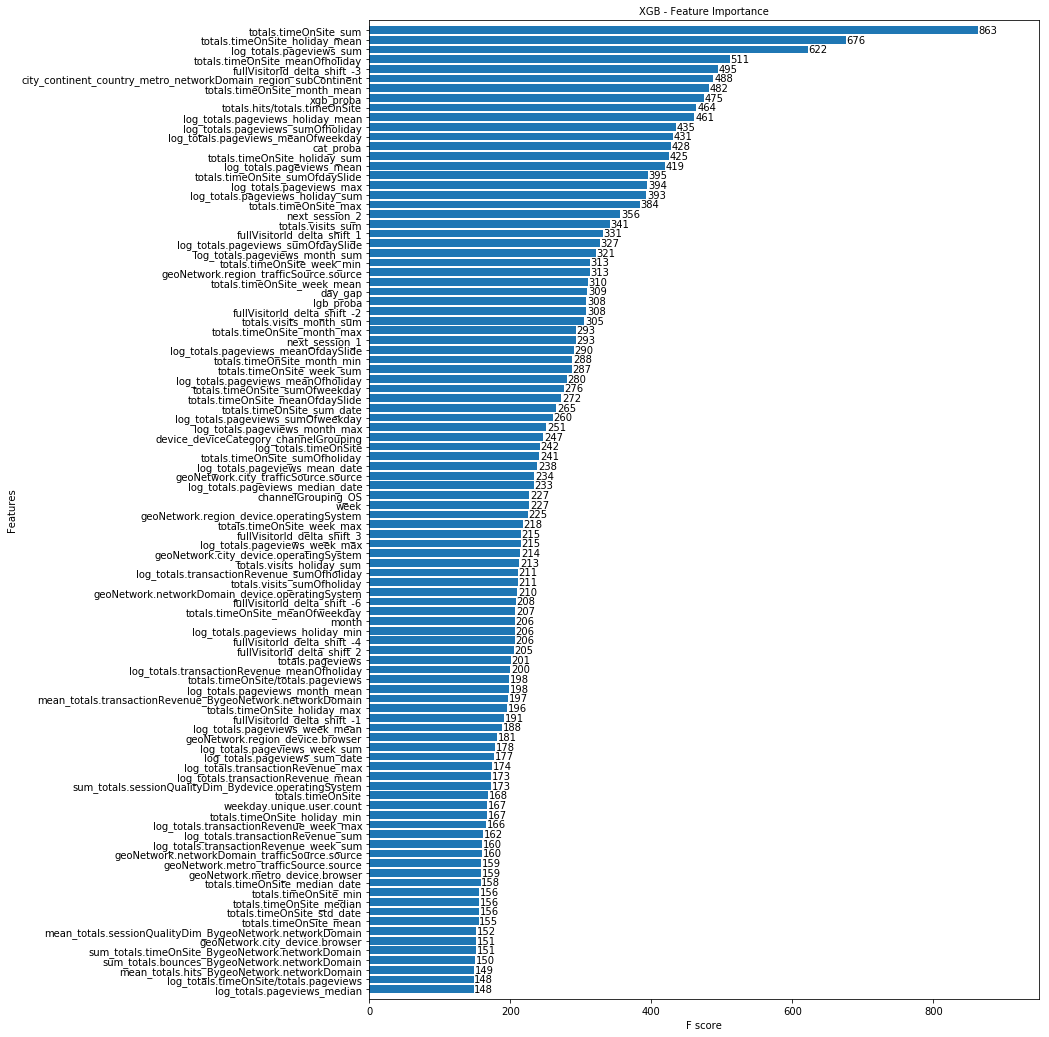

................................training_1...........................
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0372594	valid_1's binary_logloss: 0.0528189
[200]	training's binary_logloss: 0.00553201	valid_1's binary_logloss: 0.0234959
[300]	training's binary_logloss: 0.00147239	valid_1's binary_logloss: 0.0207036
[400]	training's binary_logloss: 0.000491493	valid_1's binary_logloss: 0.0232987
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00141032	valid_1's binary_logloss: 0.0205168
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0364373	valid_1's binary_logloss: 0.0451054
[200]	training's binary_logloss: 0.00606444	valid_1's binary_logloss: 0.0164915
[300]	training's binary_logloss: 0.00167712	valid_1's binary_logloss: 0.0143791
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00265693	valid_1's binary_logloss: 0.014331
Training until v

0:	learn: 0.6162139	test: 0.6162139	test1: 0.6150734	best: 0.6150734 (0)	total: 164ms	remaining: 13m 37s
100:	learn: 0.0120766	test: 0.0120766	test1: 0.0993601	best: 0.0821687 (51)	total: 17.1s	remaining: 13m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.08216874926
bestIteration = 51

Shrink model to first 52 iterations.
0:	learn: 0.6302116	test: 0.6302116	test1: 0.6565709	best: 0.6565709 (0)	total: 161ms	remaining: 13m 23s
100:	learn: 0.0123780	test: 0.0123780	test1: 0.6388461	best: 0.4067828 (18)	total: 16.9s	remaining: 13m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4067827705
bestIteration = 18

Shrink model to first 19 iterations.
0:	learn: 0.6145581	test: 0.6145581	test1: 0.6315474	best: 0.6315474 (0)	total: 159ms	remaining: 13m 13s
100:	learn: 0.0115193	test: 0.0115193	test1: 0.5970283	best: 0.3038683 (21)	total: 17.7s	remaining: 14m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3038683079
bestIt

[200]	validation_0-rmse:0.526531	validation_1-rmse:0.635248
Stopping. Best iteration:
[153]	validation_0-rmse:0.550341	validation_1-rmse:0.632241

[0]	validation_0-rmse:0.968911	validation_1-rmse:0.795943
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:0.600166	validation_1-rmse:0.627793
[200]	validation_0-rmse:0.534243	validation_1-rmse:0.619429
Stopping. Best iteration:
[233]	validation_0-rmse:0.51661	validation_1-rmse:0.616865

--------------------------------------------------model training done！--------------------------------------------------
0:	learn: 0.8335659	test: 0.8335659	test1: 0.8986173	best: 0.8986173 (0)	total: 55.1ms	remaining: 1m 50s
100:	learn: 0.5997408	test: 0.5997408	test1: 0.8757701	best: 0.8757701 (100)	total: 5.58s	remaining: 1m 44s
200:	learn: 0.5330274	test: 0.5330274	test1: 0.8674810	best: 0.8674392 (199)	total: 11.4s	remain

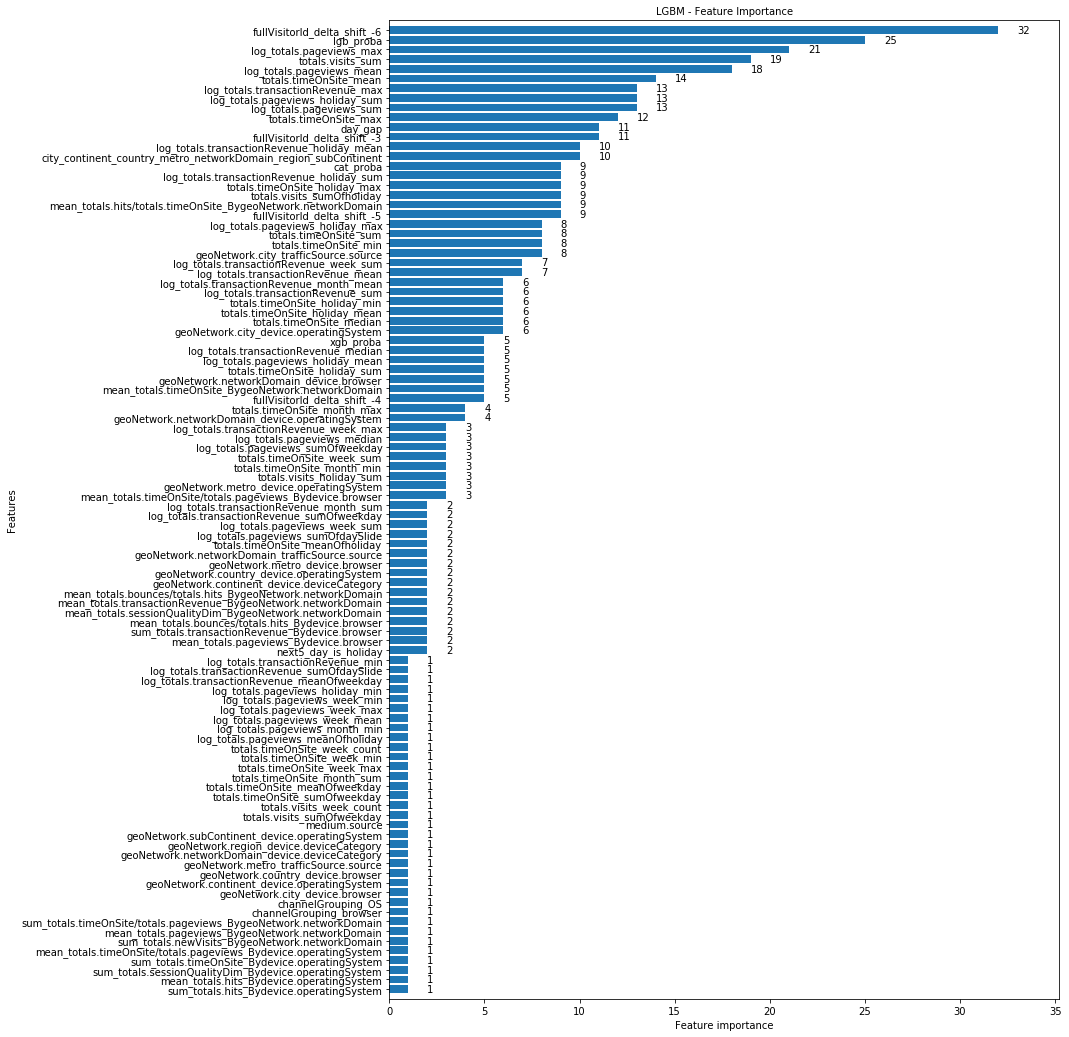

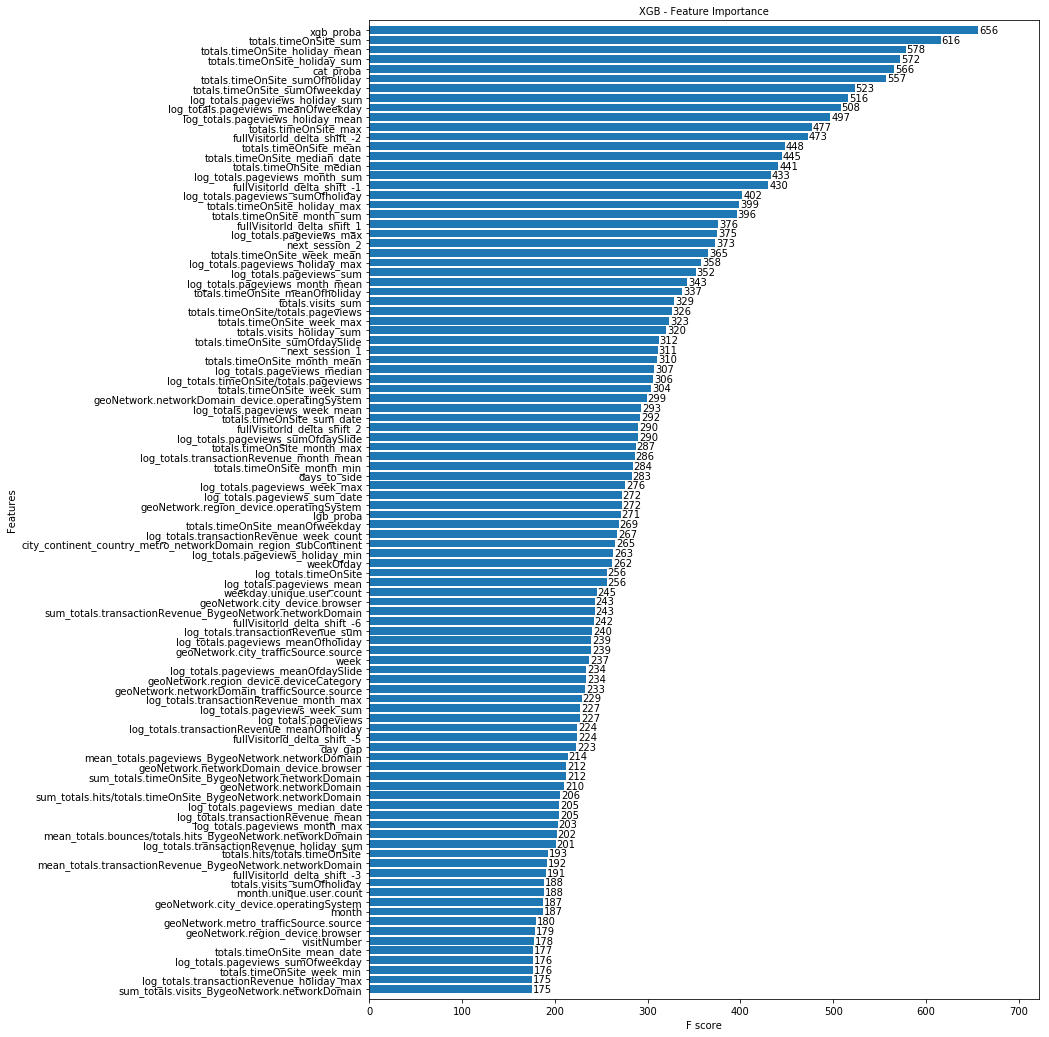

................................training_2...........................
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0348913	valid_1's binary_logloss: 0.0419499
[200]	training's binary_logloss: 0.00414978	valid_1's binary_logloss: 0.00965799
[300]	training's binary_logloss: 0.000835358	valid_1's binary_logloss: 0.00618071
[400]	training's binary_logloss: 0.000229311	valid_1's binary_logloss: 0.0062925
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000408361	valid_1's binary_logloss: 0.00607878
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0337902	valid_1's binary_logloss: 0.0391717
[200]	training's binary_logloss: 0.00369835	valid_1's binary_logloss: 0.00745457
[300]	training's binary_logloss: 0.000633419	valid_1's binary_logloss: 0.00463316
[400]	training's binary_logloss: 0.000149596	valid_1's binary_logloss: 0.00491815
Early stopping, best iteration is:
[304]

0:	learn: 0.6104434	test: 0.6104434	test1: 0.6177630	best: 0.6177630 (0)	total: 472ms	remaining: 39m 17s
100:	learn: 0.0082169	test: 0.0082169	test1: 0.3854014	best: 0.2038201 (24)	total: 52.6s	remaining: 42m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2038201332
bestIteration = 24

Shrink model to first 25 iterations.
0:	learn: 0.6161385	test: 0.6161385	test1: 0.6134640	best: 0.6134640 (0)	total: 449ms	remaining: 37m 22s
100:	learn: 0.0093778	test: 0.0093778	test1: 0.0571806	best: 0.0475607 (55)	total: 52s	remaining: 42m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04756070519
bestIteration = 55

Shrink model to first 56 iterations.
0:	learn: 0.6171360	test: 0.6171360	test1: 0.6220943	best: 0.6220943 (0)	total: 506ms	remaining: 42m 11s
100:	learn: 0.0086788	test: 0.0086788	test1: 0.5048333	best: 0.2215511 (16)	total: 52.3s	remaining: 42m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2215511112
bestIteratio

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3009406506
bestIteration = 4

Shrink model to first 5 iterations.
0:	learn: 0.7162920	test: 0.7162920	test1: 0.6065463	best: 0.6065463 (0)	total: 383ms	remaining: 12m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6064686057
bestIteration = 3

Shrink model to first 4 iterations.
0:	learn: 0.7277164	test: 0.7277164	test1: 0.4615851	best: 0.4615851 (0)	total: 232ms	remaining: 7m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4615324521
bestIteration = 2

Shrink model to first 3 iterations.
0:	learn: 0.7339257	test: 0.7339257	test1: 0.3773993	best: 0.3773993 (0)	total: 213ms	remaining: 7m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3768800194
bestIteration = 34

Shrink model to first 35 iterations.
0:	learn: 0.7085352	test: 0.7085352	test1: 0.6836057	best: 0.6836057 (0)	total: 249ms	remaining: 8m 17s
100:	learn: 0.4775769	test: 0.4775769	test1: 0

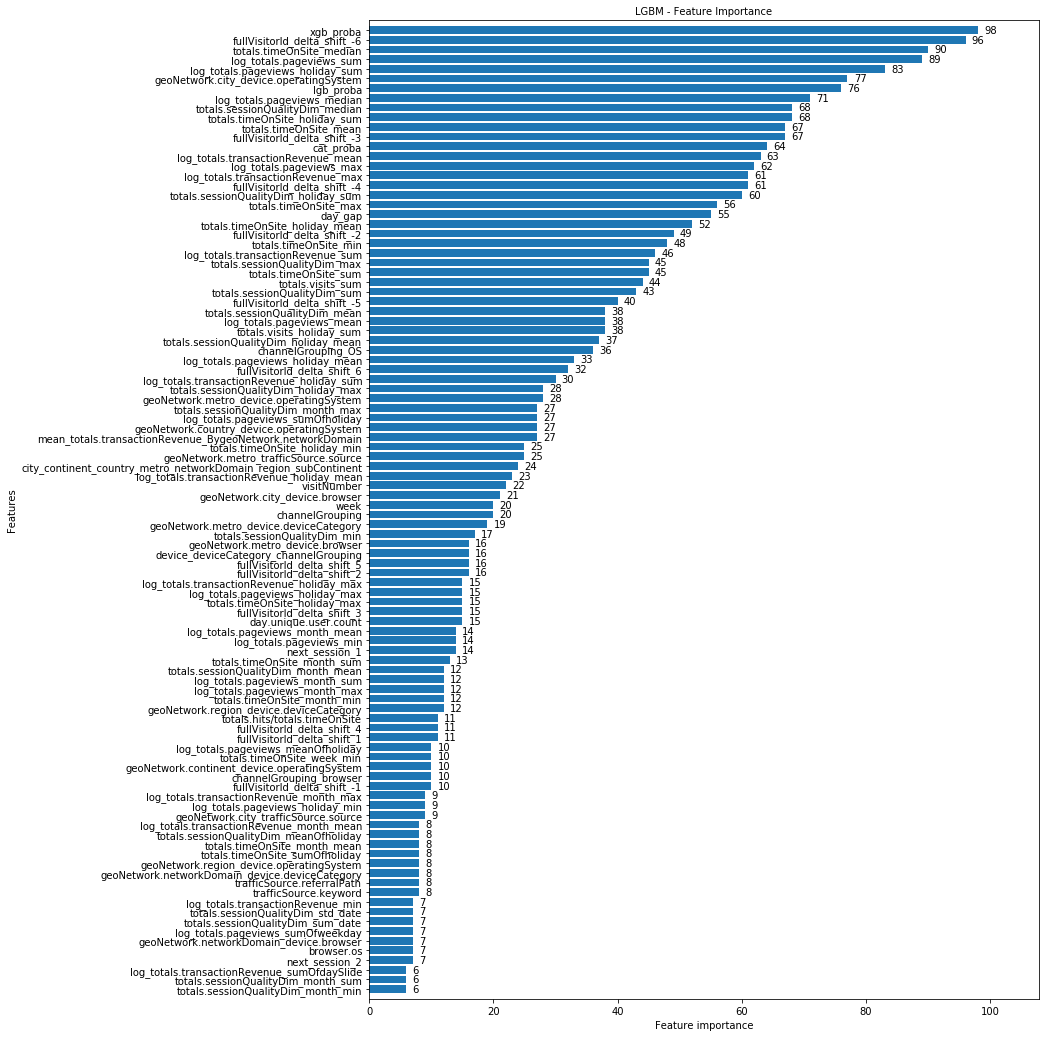

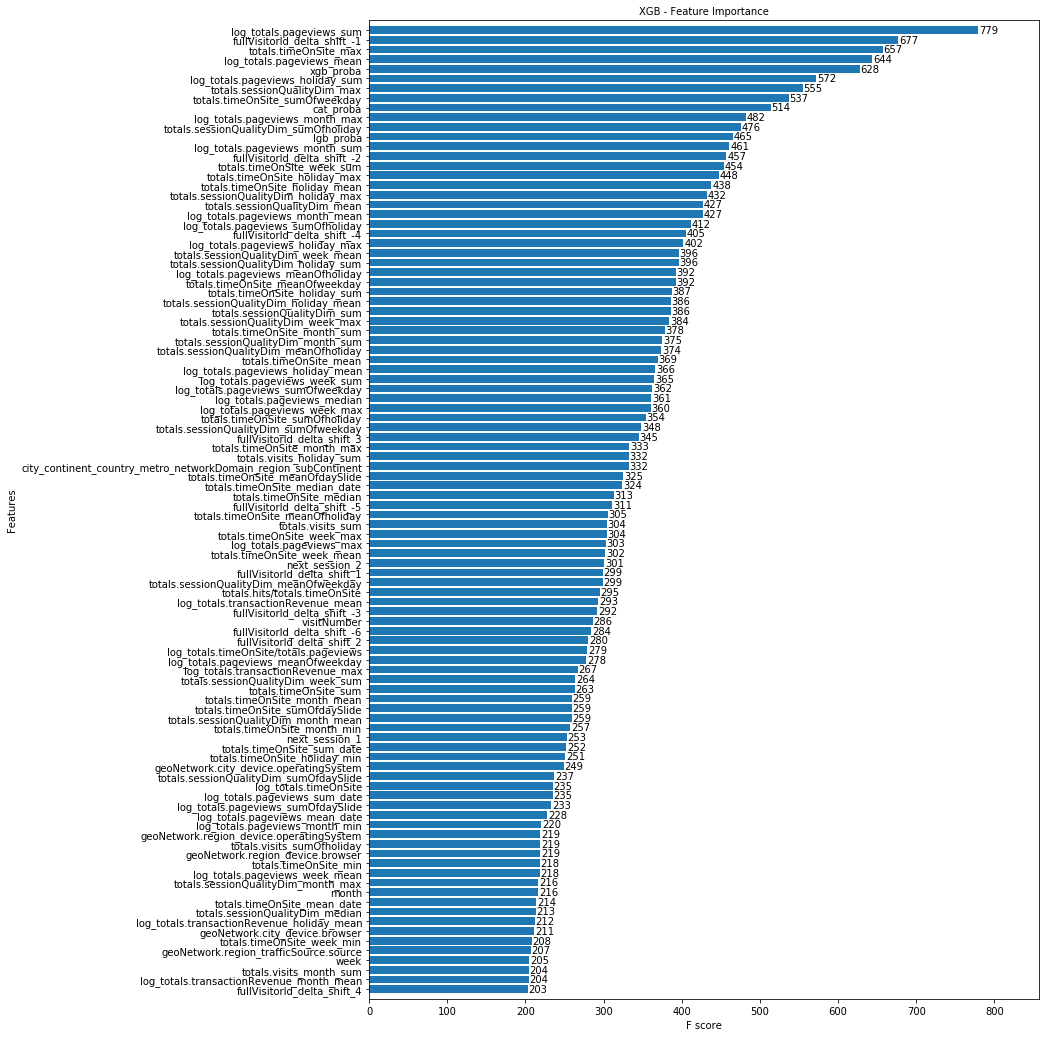

................................training_3...........................
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0259802	valid_1's binary_logloss: 0.0287159
[200]	training's binary_logloss: 0.00139745	valid_1's binary_logloss: 0.00624942
[300]	training's binary_logloss: 7.48288e-05	valid_1's binary_logloss: 0.00683677
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000674955	valid_1's binary_logloss: 0.00605803
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0264479	valid_1's binary_logloss: 0.0280476
[200]	training's binary_logloss: 0.00141152	valid_1's binary_logloss: 0.00279773
[300]	training's binary_logloss: 7.7713e-05	valid_1's binary_logloss: 0.00185156
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000130848	valid_1's binary_logloss: 0.00183175
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_

100:	learn: 0.0006890	test: 0.0006890	test1: 0.5922786	best: 0.2271046 (17)	total: 20s	remaining: 16m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2271046292
bestIteration = 17

Shrink model to first 18 iterations.
0:	learn: 0.6005392	test: 0.6005392	test1: 0.6038345	best: 0.6038345 (0)	total: 495ms	remaining: 41m 14s
100:	learn: 0.0008804	test: 0.0008804	test1: 0.1018355	best: 0.0735202 (30)	total: 49.7s	remaining: 40m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.07352020575
bestIteration = 30

Shrink model to first 31 iterations.
0:	learn: 0.5963970	test: 0.5963970	test1: 0.5972496	best: 0.5972496 (0)	total: 493ms	remaining: 41m 5s
100:	learn: 0.0008887	test: 0.0008887	test1: 0.0482223	best: 0.0313966 (39)	total: 47.4s	remaining: 38m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.03139655058
bestIteration = 39

Shrink model to first 40 iterations.
0:	learn: 0.6039421	test: 0.6039421	test1: 0.6032215	best

0:	learn: 0.3106060	test: 0.3106060	test1: 0.0923844	best: 0.0923844 (0)	total: 317ms	remaining: 10m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09238442708
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.2799982	test: 0.2799982	test1: 0.4160702	best: 0.4160702 (0)	total: 234ms	remaining: 7m 46s
100:	learn: 0.1969874	test: 0.1969874	test1: 0.4151242	best: 0.4151081 (87)	total: 21.3s	remaining: 6m 40s
200:	learn: 0.1671700	test: 0.1671700	test1: 0.4146238	best: 0.4146238 (200)	total: 42.6s	remaining: 6m 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4145755363
bestIteration = 221

Shrink model to first 222 iterations.
0:	learn: 0.3039801	test: 0.3039801	test1: 0.2105181	best: 0.2105181 (0)	total: 307ms	remaining: 10m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.210518137
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.3026650	test: 0.3026650	test1: 0.2273656	best: 0.2273

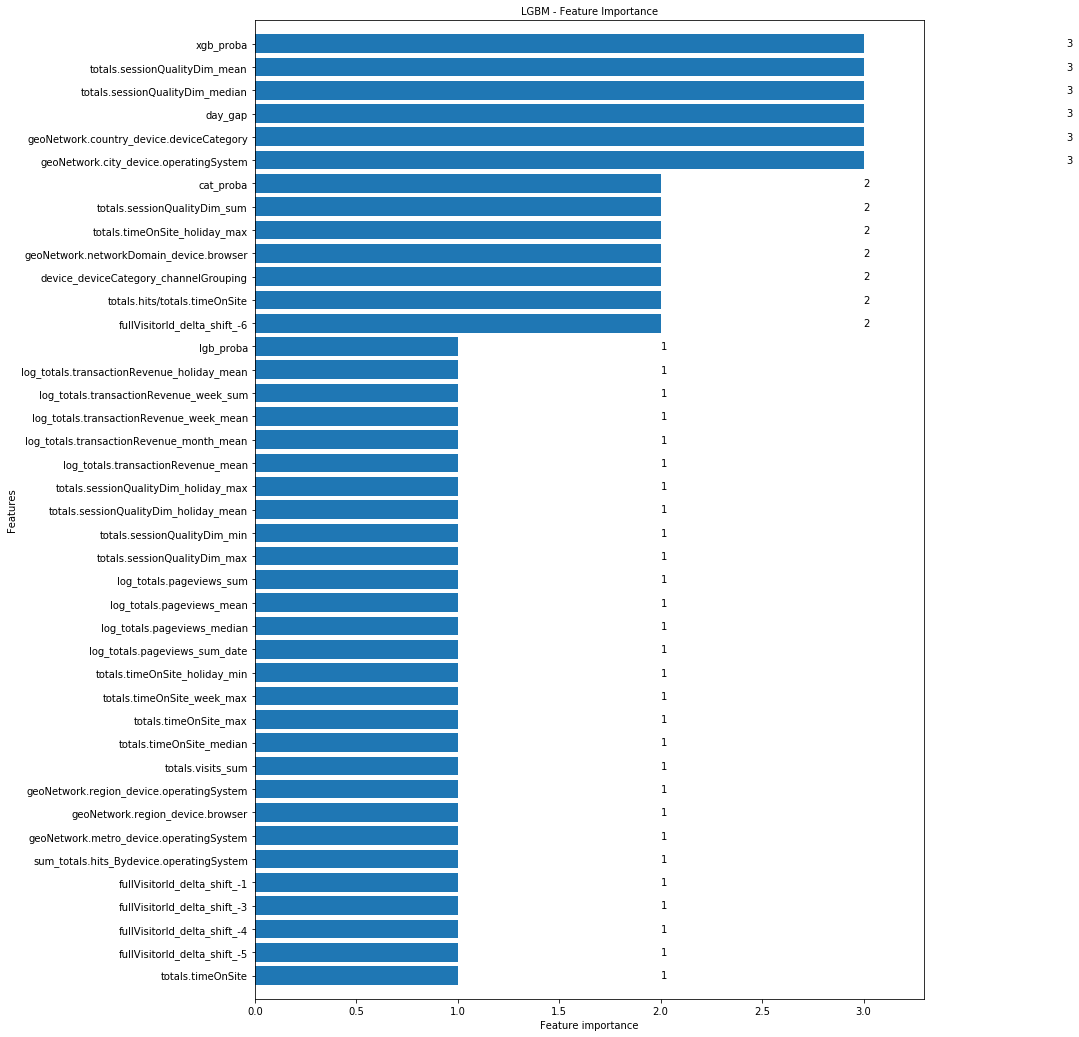

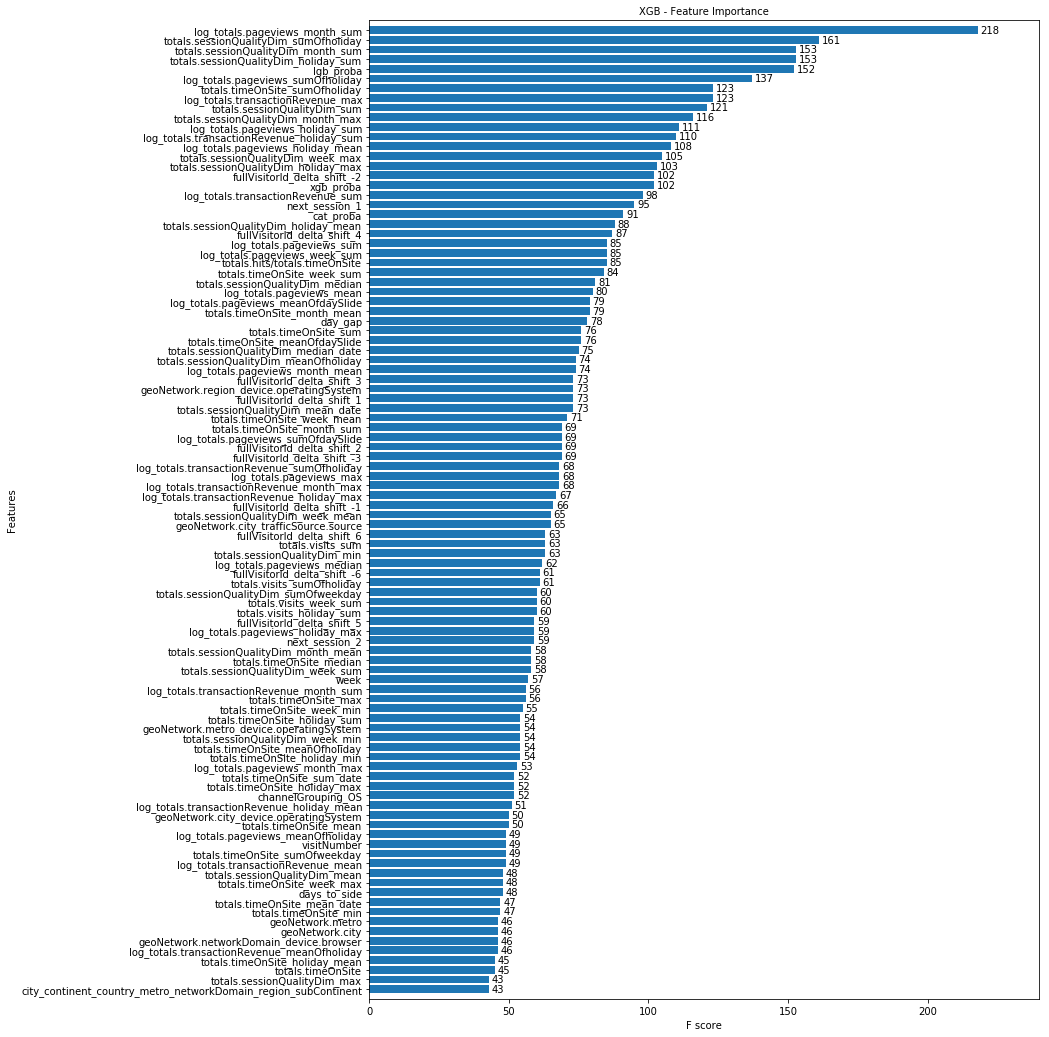

................................training_4...........................
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0374766	valid_1's binary_logloss: 0.0507229
[200]	training's binary_logloss: 0.00534178	valid_1's binary_logloss: 0.0213151
[300]	training's binary_logloss: 0.0012738	valid_1's binary_logloss: 0.016444
[400]	training's binary_logloss: 0.000393075	valid_1's binary_logloss: 0.0174006
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000946699	valid_1's binary_logloss: 0.0162996
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0349929	valid_1's binary_logloss: 0.0388763
[200]	training's binary_logloss: 0.00472116	valid_1's binary_logloss: 0.00948453
[300]	training's binary_logloss: 0.00115335	valid_1's binary_logloss: 0.00658296
[400]	training's binary_logloss: 0.00035767	valid_1's binary_logloss: 0.00651394
Early stopping, best iteration is:
[354]	trainin

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1341925813
bestIteration = 26

Shrink model to first 27 iterations.
0:	learn: 0.6156889	test: 0.6156889	test1: 0.6332247	best: 0.6332247 (0)	total: 470ms	remaining: 39m 8s
100:	learn: 0.0079120	test: 0.0079120	test1: 0.6814895	best: 0.3112177 (14)	total: 47.2s	remaining: 38m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3112177211
bestIteration = 14

Shrink model to first 15 iterations.
0:	learn: 0.6242823	test: 0.6242823	test1: 0.6253558	best: 0.6253558 (0)	total: 585ms	remaining: 48m 45s
100:	learn: 0.0090080	test: 0.0090080	test1: 0.1386749	best: 0.1092026 (30)	total: 44.5s	remaining: 35m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1092025812
bestIteration = 30

Shrink model to first 31 iterations.
0:	learn: 0.6237007	test: 0.6237007	test1: 0.6228763	best: 0.6228763 (0)	total: 612ms	remaining: 50m 58s
100:	learn: 0.0090276	test: 0.0090276	test1: 0.0747179	best:

100:	learn: 0.5193739	test: 0.5193739	test1: 1.0276159	best: 1.0276159 (100)	total: 20.7s	remaining: 6m 28s
200:	learn: 0.4738199	test: 0.4738199	test1: 0.9318930	best: 0.9311457 (182)	total: 34.4s	remaining: 5m 8s
300:	learn: 0.4484950	test: 0.4484950	test1: 0.9222860	best: 0.9215333 (268)	total: 42.7s	remaining: 4m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9215332628
bestIteration = 268

Shrink model to first 269 iterations.
0:	learn: 0.7434757	test: 0.7434757	test1: 0.5744158	best: 0.5744158 (0)	total: 312ms	remaining: 10m 22s
100:	learn: 0.5291268	test: 0.5291268	test1: 0.5671990	best: 0.5671922 (99)	total: 22.1s	remaining: 6m 55s
200:	learn: 0.4725996	test: 0.4725996	test1: 0.5602931	best: 0.5602931 (200)	total: 42.8s	remaining: 6m 23s
300:	learn: 0.4414236	test: 0.4414236	test1: 0.5574671	best: 0.5572153 (295)	total: 1m 2s	remaining: 5m 54s
400:	learn: 0.4230536	test: 0.4230536	test1: 0.5553542	best: 0.5553329 (397)	total: 1m 22s	remaining: 5m 27s
500

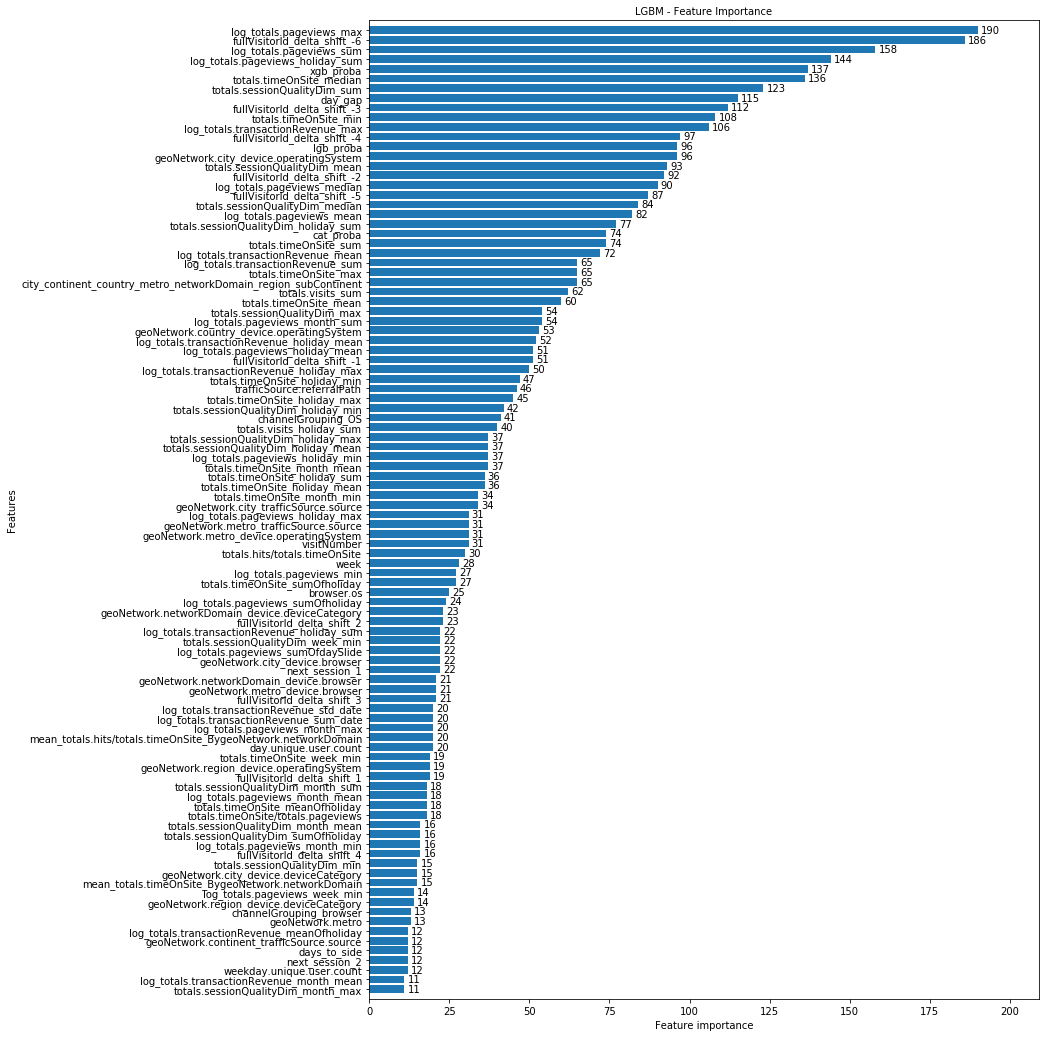

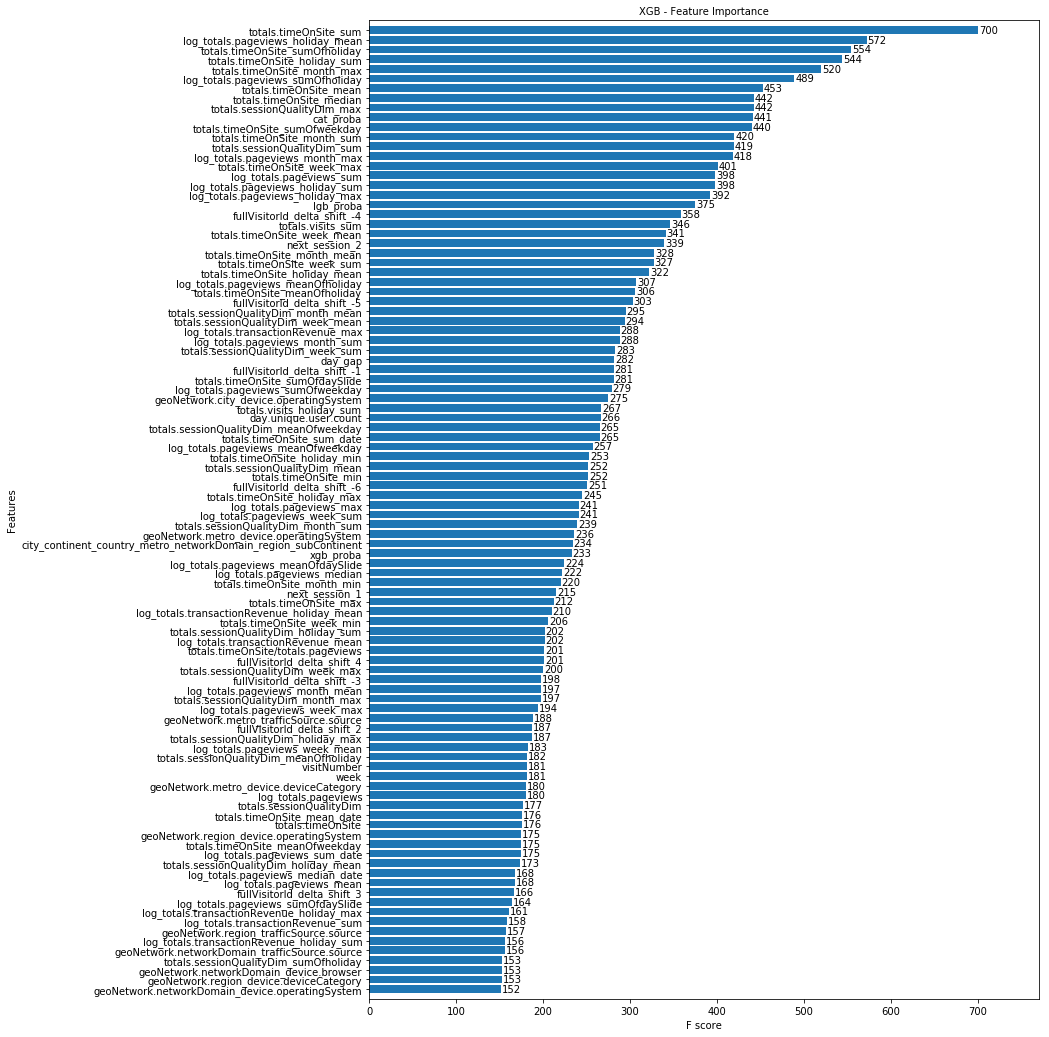

CPU times: user 2d 16h 22min 56s, sys: 3h 32min 40s, total: 2d 19h 55min 36s
Wall time: 8h 43min 42s


In [21]:
%%time
##########################################Starting training####################################################

df_test = pd.read_csv('./features/'+'df_test.csv',dtype={'fullVisitorId': np.str,'date':np.str})
excluded_cols = ['date','fullVisitorId','totals.transactionRevenue','visitStartTime',
                 'y_class','y_reg','log_totals.transactionRevenue']

for i in range(5):
    print('................................training_%s...........................'%i)
    df_train = pd.read_csv('./features/'+'df_trv%s.csv'%i,dtype={'fullVisitorId': np.str,'date':np.str})
    tr_features = [_f for _f in df_train.columns if _f not in excluded_cols]
    
    train_y = df_train['y_reg']
    
    train_label = df_train['y_class']
    df_train.drop(columns=['y_reg','y_class'],inplace=True)
##############################################Classifier#####################################################
    lgb_clf_params = {
        'num_leaves':31,
        'learning_rate':0.03,
        'n_estimators':5000,
        'class_weight':'balanced',#平衡样本
        'subsample':0.9,
        'colsample_bytree':0.9,
        'random_state':20+i,
        'objective':'binary',
        'device': 'gpu',
        'gpu_platform_id':1,
        'gpu_device_id': 1,
    }
    lgb_clf = lgb.LGBMClassifier(**lgb_clf_params)

    lgb_clf,clf_test_pred,clf_train_pred = getGroupKFoldClf(lgb_clf,df_train,train_label,df_test)
    #加入分类特征
    df_train['lgb_proba'] = clf_train_pred[:,0]
    df_test['lgb_proba'] = clf_test_pred[:,0]

    xgb_clf_params = {
        'learning_rate': 0.01,
        'n_estimators':5000,
        'scale_pos_weight':77.4,#平衡样本
        'objective':'binary:logistic',
        'max_depth': 22,
        'min_child_weight': 57,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 20+i
    }

    xgb_clf = xgb.XGBClassifier(**xgb_clf_params)
    xgb_clf,clf_test_pred,clf_train_pred = getGroupKFoldClf2(xgb_clf,df_train,train_label,df_test)
    df_train['xgb_proba'] = clf_train_pred[:,0]
    df_test['xgb_proba'] = clf_test_pred[:,0]

    cat_clf_params = {
        'n_estimators':5000,
        'learning_rate':0.02,
        'max_depth':10,
        'scale_pos_weight':77.4,#平衡样本
        'loss_function':'Logloss',
        'eval_metric':'Logloss',
        'random_state':20,
        'bagging_temperature':0.2,
        'od_type':'Iter',
        'od_wait':20+i
    }
    cat_clf = catb.CatBoostClassifier(**cat_clf_params)

    cat_clf,clf_test_pred,clf_train_pred = getGroupKFoldClf2(cat_clf,df_train,train_label,df_test)

    df_train['cat_proba'] = clf_train_pred[:,0]
    df_test['cat_proba'] = clf_test_pred[:,0]

######################################Regressions With GroupKFold###########################################

    tr_features = [_f for _f in df_train.columns if _f not in excluded_cols]

    lgb_params={
        'learning_rate': 0.03,
        'objective':'regression',
        'n_estimators':2000,
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "random_state":42,
        'max_depth': 15,
        'lambda_l2': 0.02,
        'lambda_l1': 0.004,
        'device': 'gpu',
        'gpu_platform_id':1,
        'gpu_device_id': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.7,
        'min_child_samples': 21
    }
    lgb_est = lgb.LGBMRegressor(**lgb_params)
    lgb_est,oof_lgb_test_pred,oof_lgb_train_pred = getGroupKFoldReg(lgb_est,df_train,train_y,df_test)

    xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'n_estimators':2000,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 20+i
    }
    xgb_est = xgb.XGBRegressor(**xgb_params)
    xgb_est,oof_xgb_test_pred,oof_xgb_train_pred = getGroupKFoldReg2(xgb_est,df_train,train_y,df_test)
    # xgb_est.save_model('xgb_est_session.model')
    
    cat_params = {
            'n_estimators':2000,
            'learning_rate':0.01,
            'max_depth':7,
            'loss_function':'RMSE',
            'eval_metric':'RMSE',
            'random_state':42+i,
            'bagging_temperature':0.2,
            'od_type':'Iter',
            'od_wait':20
        }
    cat_est = catb.CatBoostRegressor(**cat_params)
    cat_est,oof_cat_test_pred,oof_cat_train_pred = getGroupKFoldReg2(cat_est,df_train,train_y,df_test)

    #特征重要性分析
    fig, ax = plt.subplots(figsize=(12,18))
    lgb.plot_importance(lgb_est,max_num_features=100, height=0.8, ax=ax)
    ax.grid(False)
    plt.title("LGBM - Feature Importance", fontsize=10)
    plt.show()
    
    #特征重要性分析
    fig, ax = plt.subplots(figsize=(12,18))
    xgb.plot_importance(xgb_est,max_num_features=100, height=0.8, ax=ax)
    ax.grid(False)
    plt.title("XGB - Feature Importance", fontsize=10)
    plt.show()
    
    cat_est.get_feature_importance(prettified=True)

    oof_test_pred = oof_lgb_test_pred*0.3 + oof_xgb_test_pred*0.3 + oof_cat_test_pred*0.4
#     oof_train_pred = oof_lgb_train_pred*0.2+ oof_xgb_train_pred*0.4  + oof_cat_train_pred*0.4 
    df_test['oof_test_pred_%s'%i] = oof_test_pred
    

In [22]:
import datetime
flagtime  = datetime.datetime.now()
flagtime = datetime.datetime.strftime(flagtime,'%Y%m%d%H%M')

df_correct = df_test.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
df_correct['totals.transactionRevenue'] = df_correct['totals.transactionRevenue'].apply(lambda x:np.log1p(float(x)) if float(x) > 0 else 0)

df_sub = df_test.groupby(['fullVisitorId'])['oof_test_pred_0','oof_test_pred_1','oof_test_pred_2','oof_test_pred_3',
                         'oof_test_pred_4'].mean().reset_index()
df_sub['PredictedLogRevenue'] = (df_sub['oof_test_pred_0']+df_sub['oof_test_pred_1']+\
                df_sub['oof_test_pred_2']+df_sub['oof_test_pred_3']+df_sub['oof_test_pred_4'])/5
df_sub['PredictedLogRevenue'] = df_sub['PredictedLogRevenue'].apply(lambda x:np.log1p(float(x)) if float(x) else 0)
df_sub.fillna(0,inplace=True)

loss = mean_squared_error(df_sub['PredictedLogRevenue'].values,df_correct['totals.transactionRevenue'].values)
print("loss = %s"%str(loss))

df_sub[['fullVisitorId','PredictedLogRevenue']].to_csv(sub_dir+'submission_%s.csv'%loss,index=False)

loss = 4.413053242700916
